# Imports

In [2]:
# General modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import sep
from tqdm import tqdm

# Enable re-load of local modules every time they are called
%load_ext autoreload
%autoreload 2
%aimport numpy 
%aimport pandas

# Load data

## Teacher data

In [187]:
home_folder = 'Documents{0}CEGIS{0}DiscSim'.format(sep)
filename = 'ee_data.csv'

teacher_data = pd.read_csv(filename) # Read data from the excel sheet
teacher_variables = data.columns       # Each column is a single variable measured, this gives the names of columns
teacher_n_variables = len(variables)
teacher_n_rows = len(teacher_data[teacher_variables[0]])

print('The following variables were found in this dataset:')
for v in teacher_variables:
    print('    {0}'.format(v))

The following variables were found in this dataset:
    identifier
    student_id
    Subject
    1st question Level
    1st level score
    2nd question Level
    2nd level score
    3rd question Level
    3rd level score
    Cluster ID
    School ID
    district
    Teacher User ID
    class
    baseline
    Student Identifier


## Supervisor data

In [188]:
home_folder = 'Documents{0}CEGIS{0}DiscSim'.format(sep)
filename = 'ee_ees_data.csv'.format(home_folder, sep)

sup_data = pd.read_csv(filename) # Read data from the excel sheet
sup_variables = sup_data.columns       # Each column is a single variable measured, this gives the names of columns
sup_n_variables = len(sup_variables)
sup_n_rows = len(sup_data[sup_variables[0]])

print('The following variables were found in this dataset:')
for v in sup_variables:
    print('    {0}'.format(v))

The following variables were found in this dataset:
    UID
    district
    block id
    cluster id
    Student Identifier
    school id
    subject
    class
    baseline
    1st question Level
    1st level score
    2nd question Level
    2nd level score
    3rd question Level
    3rd level score
    Admin User ID


# Calculate discrepancy

## Select all samples for a given teacher

1920 teacher IDs found


100%|███████████████████████████████████████| 1920/1920 [01:00<00:00, 31.63it/s]


Text(0, 0.5, 'Number of teachers')

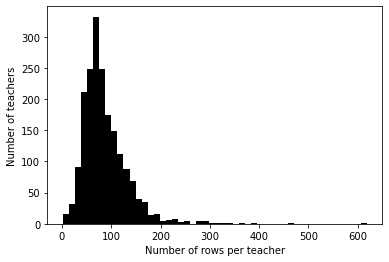

In [164]:
teacher_ids = list(np.unique(list(teacher_data['Teacher User ID'])))
n_teachers = len(teacher_ids)
print('{0} teacher IDs found'.format(n_teachers))

row_nos_per_teacher = {}
n_rows_per_teacher = np.empty(n_teachers, dtype = int)

i = 0
for teacher_id in tqdm(teacher_ids):
    row_nos_per_teacher[teacher_id] = np.where(list(teacher_data['Teacher User ID']) == teacher_id)[0]
    n_rows_per_teacher[i] = len(row_nos_per_teacher[teacher_id])
    i += 1

n_rows_per_teacher = [len(v) for v in list(row_nos_per_teacher.values())]
plt.figure()
plt.hist(n_rows_per_teacher, 50, color = 'k')
plt.xlabel('Number of rows per teacher')
plt.ylabel('Number of teachers')

In [116]:
teacher_student_ids = list(teacher_data['identifier'])
student_ids_per_teacher = {}

for teacher_id in teacher_ids:
    student_ids_per_teacher[teacher_id] = [teacher_student_ids[row] for row in row_nos_per_teacher[teacher_id]]

n_student_ids_per_teacher = [len(np.unique(s)) for s in list(student_ids_per_teacher.values())]
assert(n_student_ids_per_teacher == n_rows_per_teacher)

## Fetch supervisor entries for each teacher

100%|███████████████████████████████████████| 1920/1920 [00:45<00:00, 42.65it/s]


Text(0, 0.5, 'Number of teachers')

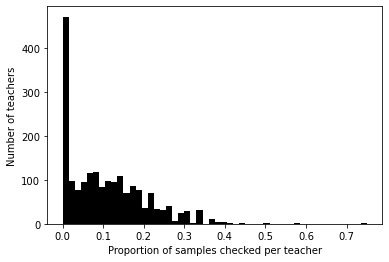

In [120]:
sup_student_ids = list(sup_data['UID'])
n_sup_student_ids = len(sup_student_ids)
assert(len(np.unique(sup_student_ids)) == n_sup_student_ids)

sup_row_nos_per_teacher = {teacher_id: {} for teacher_id in teacher_ids}
n_rows_checked_per_teacher = np.zeros(n_teachers)

for teacher_id in tqdm(teacher_ids):
    
    sup_row_nos_per_teacher[teacher_id] = [i for i in range(n_sup_student_ids) if sup_student_ids[i] in student_ids_per_teacher[teacher_id]]
    n_rows_checked_per_teacher[list(teacher_ids).index(teacher_id)] = len(sup_row_nos_per_teacher[teacher_id])
        
assert(len(n_rows_checked_per_teacher) == n_teachers)
plt.figure()
plt.hist(np.divide(np.array(n_rows_checked_per_teacher), np.array(n_rows_per_teacher)), 50, color = 'k')
plt.xlabel('Proportion of samples checked per teacher')
plt.ylabel('Number of teachers')

In [122]:
for n_samples in range(1, 11):
    
    print('{0} teachers have at least {1} samples checked'.format(np.sum(n_rows_checked_per_teacher > n_samples), n_samples))

1430 teachers have at least 1 samples checked
1366 teachers have at least 2 samples checked
1290 teachers have at least 3 samples checked
1198 teachers have at least 4 samples checked
1134 teachers have at least 5 samples checked
1057 teachers have at least 6 samples checked
1007 teachers have at least 7 samples checked
936 teachers have at least 8 samples checked
892 teachers have at least 9 samples checked
855 teachers have at least 10 samples checked


## Get Levels and Scoresn_scores

In [190]:
teacher_constants = ['Subject', 'class']
sup_constants = ['subject', 'class']

teacher_level_variables = ['1st question Level',  '2nd question Level', '3rd question Level', 'baseline']
sup_level_variables = ['1st question Level', '2nd question Level', '3rd question Level', 'baseline']
n_levels = len(teacher_level_variables)
level_values = ['Arumbu', 'Mottu', 'Malar']

teacher_score_variables = ['1st level score', '2nd level score', '3rd level score']
sup_score_variables = ['1st level score', '2nd level score', '3rd level score']
n_scores = len(teacher_score_variables)

print('Checking level data entries for teachers')
for row in tqdm(range(teacher_n_rows)):
    assert(teacher_data['1st question Level'][row] in level_values)
    assert(teacher_data['1st question Level'][row] == teacher_data['baseline'][row])
    for v in ['2nd question Level', '3rd question Level']:
        assert(teacher_data[v][row] in level_values or np.isnan(teacher_data[v][row]))

print('Checking level data entries for supervisors')
for row in tqdm(range(sup_n_rows)):
    assert(sup_data['1st question Level'][row] in level_values)
    assert(sup_data['1st question Level'][row] == sup_data['baseline'][row])
    for v in ['2nd question Level', '3rd question Level']:
        assert(sup_data[v][row] in level_values or np.isnan(sup_data[v][row]))

Checking level data entries for teachers


100%|████████████████████████████████| 166850/166850 [00:07<00:00, 23393.67it/s]


Checking level data entries for supervisors


100%|██████████████████████████████████| 13577/13577 [00:00<00:00, 21842.83it/s]


## Calculate discrepancy

In [193]:
score_discrepancy = {}
level_discrepancy = {}

for teacher_id in tqdm(teacher_ids):
    
    row_nos = list(row_nos_per_teacher[teacher_id])
    student_ids = list(student_ids_per_teacher[teacher_id])
    
    sup_row_nos = list(sup_row_nos_per_teacher[teacher_id])
    
    if len(sup_row_nos) > 0:
        
        level_disc = np.zeros(len(sup_row_nos), dtype = bool)
        score_disc = np.zeros(len(sup_row_nos), dtype = bool)
        
        for sup_row in sup_row_nos:
            
            student_id = sup_student_ids[sup_row]
            teacher_row_no = row_nos[student_ids.index(student_id)]
            for c in range(len(teacher_constants)):
                assert(teacher_data[teacher_constants[c]][teacher_row_no] == sup_data[sup_constants[c]][sup_row])
                
            teacher_levels = [teacher_data[v][teacher_row_no] for v in teacher_level_variables]
            teacher_scores = [teacher_data[v][teacher_row_no] for v in teacher_score_variables]
            
            sup_levels = [sup_data[v][sup_row] for v in sup_level_variables]
            sup_scores = [sup_data[v][sup_row] for v in sup_score_variables]
            
            for i in range(n_levels):
                if np.logical_or(~isinstance(teacher_levels[i], str), ~isinstance(sup_levels[i], str)):
                    break
                if not teacher_levels[i] == sup_levels[i]:
                    level_disc[sup_row_nos.index(sup_row)] = 1
                    break
                
            score_disc[sup_row_nos.index(sup_row)] = np.mean([np.abs(teacher_scores[i] - sup_scores[i]) for i in range(n_scores) if np.logical_and(~np.isnan(teacher_scores[i]), ~np.isnan(sup_scores[i]))])
                    
        level_discrepancy[teacher_id] = np.sum(level_disc)/len(sup_row_nos)
        score_discrepancy[teacher_id] = np.mean(score_disc)


100%|██████████████████████████████████████| 1920/1920 [00:02<00:00, 780.45it/s]


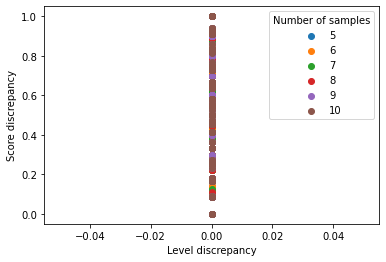

In [194]:
plt.figure()
for n_samples in range(5, 11):
    
    teacher_ids_selected = [teacher_ids[i] for i in range(n_teachers) if n_rows_checked_per_teacher[i] > n_samples]
    level_disc = [level_discrepancy[teacher_id] for teacher_id in teacher_ids_selected]
    score_disc = [score_discrepancy[teacher_id] for teacher_id in teacher_ids_selected]
    plt.scatter(level_disc, score_disc, marker = 'o', label = n_samples)

plt.xlabel('Level discrepancy')
plt.ylabel('Score discrepancy')
plt.legend(title = 'Number of samples')

(array([ 10.,  21.,  30.,  46.,  59., 142., 131., 102., 113., 201.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

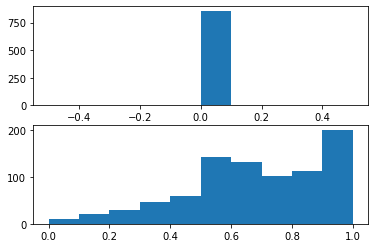

In [195]:
n_samples = 10
teacher_ids_selected = [teacher_ids[i] for i in range(n_teachers) if n_rows_checked_per_teacher[i] > n_samples]
level_disc = [level_discrepancy[teacher_id] for teacher_id in teacher_ids_selected]
score_disc = [score_discrepancy[teacher_id] for teacher_id in teacher_ids_selected]

fig, ax = plt.subplots(nrows = 2, ncols = 1)
ax[0].hist(level_disc)
ax[1].hist(score_disc)

(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  17.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  1.,   1.,   2.,   1.,   1.,   0.,   4.,  16.,   0., 803.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <matplotlib.collections.QuadMesh at 0x146a27150>)

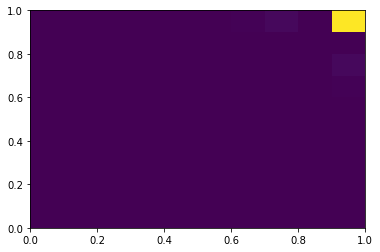

In [186]:
plt.figure()
plt.hist2d(level_disc, score_disc, )

In [166]:
for v in teacher_variables:
    print('{0}:{1}'.format(v, teacher_data[v][teacher_row_no]))

identifier:027746153_3
student_id:1027746153
Subject:Tamil
1st question Level:Mottu
1st level score:0
2nd question Level:Malar
2nd level score:0.0
3rd question Level:nan
3rd level score:nan
Cluster ID:33061802506
School ID:33061802503
district:TIRUVANNAMALAI
Teacher User ID:20066393
class:3
baseline:Mottu
Student Identifier:27746153


In [167]:
for v in sup_variables:
    print('{0}:{1}'.format(v, sup_data[v][sup_row]))

UID:027746153_3
district:TIRUVANNAMALAI
block id:115
cluster id:33061802506
Student Identifier:27746153
school id:33061802503
subject:Tamil
class:3
baseline:Arumbu
1st question Level:Arumbu
1st level score:2
2nd question Level:nan
2nd level score:nan
3rd question Level:nan
3rd level score:nan
Admin User ID:30649663


# Random sampling

In [31]:
student_id = data.get('Student Identifier')
n_students = len(np.unique(student_id.values))
print('{0} student IDs'.format(n_students))

10291 student IDs


In [40]:
len(student_id.values)

13577